Example taken from the book "Towing Icebergs, falling dominoes, and other adventures in applied mathematics" by Robert B. Banks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from sympy import *
import pandas as pd
from pivottablejs import pivot_ui

# Reading the data

In [2]:
df = pd.read_csv("./world-development-indicators/usgs_1960_2021.csv")

In [5]:
#print(df.shape)
#print(len(df.index))
#print(len(df))

In [ ]:
df.tail()

In [9]:
#Select indicators from 1960 till 2017
#df = df[:58]
df = df[(df['Year'] < 2018)]

In [ ]:
# GDP $ billion, population million, Gross Public Debt $ billion

df.tail()

In [11]:
df.columns

Index(['Year', 'GDP-US $ billion nominal', 'Population-US million',
       'Gross Public Debt-fed $ billion nominal'],
      dtype='object')

In [12]:
df.columns = ['Year', 'GDP', 'Population', 'Debt']

Total Public Debt as Percent of Gross Domestic Product

In [13]:
df['Debt_GDP'] = (df['Debt'] / df['GDP']) * 100

In [14]:
df.head(10)

,Year,GDP,Population,Debt,Debt_GDP
0,1960,543.3,179.323,290.53,53.475060
1,1961,563.3,181.588,292.65,51.952778
2,1962,605.1,183.881,302.93,50.062800
3,1963,638.6,186.204,310.32,48.593799
4,1964,685.8,188.555,316.06,46.086323
5,1965,743.7,190.937,322.32,43.340056
6,1966,815.0,193.348,328.50,40.306748
7,1967,861.7,195.790,340.45,39.509110
8,1968,942.5,198.263,368.69,39.118302
9,1969,1019.9,200.766,365.77,35.863320


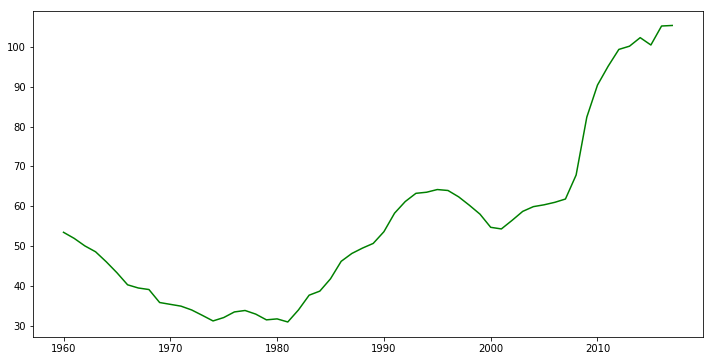

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['Year'], df['Debt_GDP'], color = 'green', label = 'Debt_GDP')
#ax.scatter(df['Year'], df['GDP'], s = 2, color = 'blue', label = 'GDP')
#ax.scatter(df['Year'], df['Debt'], s = 2, color = 'red', label = 'Debt')
#ax.scatter(df['Year'], df['Population'], s = 2, color = 'brown', label = 'Population')
#ax.set_xlabel('Year')
#ax.set_ylabel('GDP')
#ax.legend()


We can see there are huge sums owing to the US, Is there a risk of another financial crisis?

In [16]:
years = [1970, 1972, 1974, 1976, 1978, 1980, 1982, 1984, 1986, 1988, 1990, 1992]

In [17]:
ex = df.loc[df['Year'].isin(years)]

In [18]:
new_index = np.arange(12)
t = np.arange(0, 23, 2)

In [19]:
ex = ex.set_index(new_index)
ex['t'] = t

In [20]:
ex.head()

,Year,GDP,Population,Debt,Debt_GDP,t
0,1970,1075.9,203.302,380.92,35.404777,0
1,1972,1282.4,207.752,435.94,33.994074,2
2,1974,1548.8,212.299,483.89,31.242898,4
3,1976,1877.6,216.945,628.97,33.498615,6
4,1978,2356.6,221.694,776.60,32.954256,8


# Exponential function

In [2]:
init_printing()

Let's asume that the data of the federal debt ($N$) of the United States for the period 1970 to 1992 can be described by the exponential growth relationship:

$$\frac{dN}{dt} = aN$$

where $a$ is the growth coeffcient or interest rate. We can solve an ordinary differential equation in Python with SymPy

In [4]:
t, a, N0 = symbols('t, a, N_0')
N = Function('N')

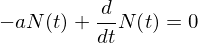

In [5]:
Eq(N(t).diff(t) - a*N(t), 0)

In [6]:
ode_sol = dsolve(_, N(t))

In [7]:
ode_sol

Another way to solve this equation is

In [8]:
ode_sol = dsolve(Derivative(N(t), t) - a* N(t), N(t))

In [9]:
ode_sol

The general solution includes an unknown integration constant $C_1$ that we have to determine from the initial conditions for the problem. Here the initial condition is $N(0) = N_0$

In [10]:
ics = {N(0): N0}

In [11]:
ics

In [12]:
C_eq = Eq(ode_sol.lhs.subs(t, 0).subs(ics), ode_sol.rhs.subs(t, 0))

In [13]:
C_eq

In [14]:
C_sol = solve(C_eq)

In [15]:
C_sol

We can substitute the solution for $C_1$, which is trivial is this case, into the general solution of the differential equation problem to obtain the particular solution that corresponds to the given initial conditions

In [16]:
ode_sol.subs(C_sol[0])

Taking the logarithms of both sides of that equation gives the expression:

$$log_e N = log_e N_0 + at$$

which has the mathematical form of straight line and can be solved using least-squares regression.

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

c:\python36-32\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
model = smf.ols("np.log(Debt) ~ t", ex)

In [23]:
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(Debt)   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1152.
Date:                Mon, 22 Oct 2018   Prob (F-statistic):           1.16e-11
Time:                        17:31:03   Log-Likelihood:                 14.551
No. Observations:                  12   AIC:                            -25.10
Df Residuals:                      10   BIC:                            -24.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8021      0.043    135.526      0.0

c:\python36-32\lib\site-packages\scipy\stats\stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [24]:
p = model.fit().params

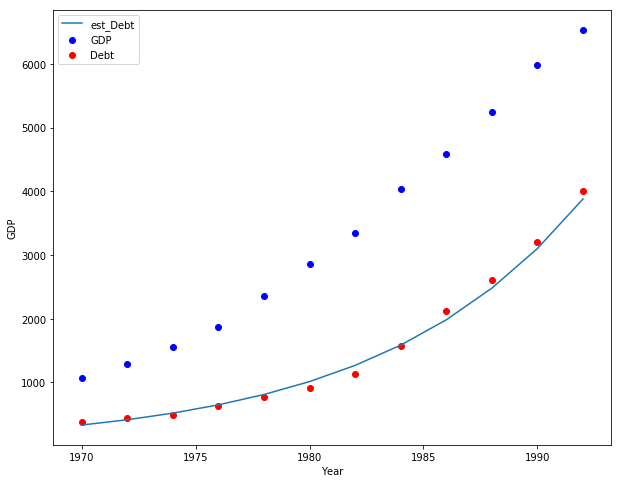

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ex['Year'], ex['GDP'], color = 'blue', label = 'GDP')
ax.scatter(ex['Year'], ex['Debt'], color = 'red', label = 'Debt')
ax.plot(ex['Year'], (np.exp(p.Intercept) * np.exp(p.t*ex['t'])), label = 'est_Debt')
ax.set_xlabel('Year')
ax.set_ylabel('GDP')
ax.legend()

# Logistic function

One possible model for the growth of a population is the logistic equation:

$$\frac{dG}{dt} = rG(1 - \frac{G}{G_*})$$

Where $G_*$ is the value of $G$ as $t \rightarrow \infty$ and $r$ is a growth coefficient. Here we are going to try to fit a logistic curve to the *GDP* data. The relationship of the latter equation can be written in the form:

$$\frac{1}{G} \frac{dG}{dt} = r - \frac{r}{G_*}G$$

This is the equation of a straight line. Utilizing the data of the table and performing a least-square regression gives the values $G_* = 11653.78$ and $r = 0.117$. The solution of the logistic differential equation with $G(t = 0) = G_0$ is:

$$G = \frac{G_*}{1 + (\dfrac{G_*}{G_0} - 1)e^{-rt}}$$


In [26]:
y = [(((ex['GDP'][i+2] - ex['GDP'][i]) / 4) / ex['GDP'][i+1]) for i in range(10)]

In [27]:
x = ex['GDP'][1:11]

In [28]:
data = pd.DataFrame({'x':x, 'y':y})

In [29]:
log_model = smf.ols("y ~ x", data)

In [30]:
print(log_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     42.30
Date:                Mon, 22 Oct 2018   Prob (F-statistic):           0.000187
Time:                        17:31:20   Log-Likelihood:                 35.885
No. Observations:                  10   AIC:                            -67.77
Df Residuals:                       8   BIC:                            -67.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1170      0.006     20.765      0.0

c:\python36-32\lib\site-packages\scipy\stats\stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [31]:
log_p = log_model.fit().params

In [32]:
log_p

Intercept    0.117046
x           -0.000010
dtype: float64

In [33]:
Ginf = -log_p.Intercept / log_p.x
print(Ginf)

11653.784409510685


In [34]:
G0 = ex.loc[ex['Year'] == 1970, 'GDP'].values[0]

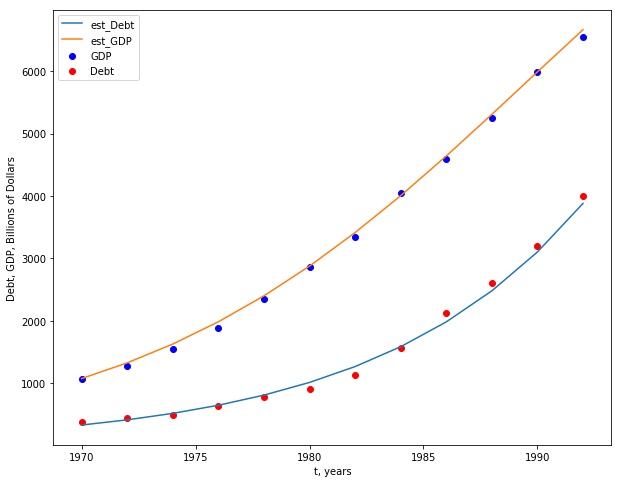

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ex['Year'], ex['GDP'], color = 'blue', label = 'GDP')
ax.scatter(ex['Year'], ex['Debt'], color = 'red', label = 'Debt')
ax.plot(ex['Year'], (np.exp(p.Intercept) * np.exp(p.t*ex['t'])), label = 'est_Debt')
ax.plot(ex['Year'], (Ginf / (1 + (((Ginf/G0) - 1)*np.exp(-log_p.Intercept*ex['t'])))), label = 'est_GDP')
ax.set_xlabel('t, years')
ax.set_ylabel('Debt, GDP, Billions of Dollars')
ax.legend()

Below is the plot showing the intersection point

In [91]:
df30 = pd.DataFrame({'t': np.arange(0, 31, 2),
                     'years' : np.arange(1970, 2001, 2)})

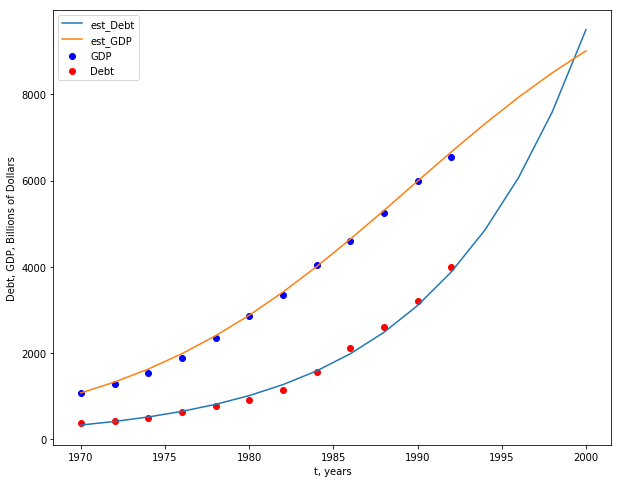

In [95]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ex['Year'], ex['GDP'], color = 'blue', label = 'GDP')
ax.scatter(ex['Year'], ex['Debt'], color = 'red', label = 'Debt')
ax.plot(df30['years'], (np.exp(p.Intercept) * np.exp(p.t*df30['t'])), label = 'est_Debt')
ax.plot(df30['years'], (Ginf / (1 + (((Ginf/G0) - 1)*np.exp(-log_p.Intercept*df30['t'])))), label = 'est_GDP')
ax.set_xlabel('t, years')
ax.set_ylabel('Debt, GDP, Billions of Dollars')
ax.legend()
